# ARMA-GARCH

Modeling price log return with ARMA-GARCH.

Usually ARMA and ARIMA assume there is constant varance in a time series, which is not always true, expecitial for financial time series data. Financial time series data like stock prices, Bitcoin prices, they have a phenomenon named **volatility clustering**, which is that the variance of returns or log returns is high for a short period and then low for next many periods. 

In [1]:
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from arch import arch_model
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller as ADF

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. Data Exploration

In [3]:
from utils import read_bars as read_bars_tmp

# Read bars in May 2020
def read_bars(csv_file: str)->pd.DataFrame:
    TIME_BEGIN = pd.to_datetime('2020-05-01T00:00:00.000Z')
    TIME_END = pd.to_datetime('2020-06-01T00:00:00.000Z')
    # TIME_BEGIN = pd.to_datetime('2020-05-12T00:00:00.000Z')
    # TIME_END = pd.to_datetime('2020-05-14T00:00:00.000Z')
    bars_df = read_bars_tmp(csv_file)
    bars_df = bars_df[(bars_df['timestamp'] >= TIME_BEGIN) & (bars_df['timestamp_end'] < TIME_END)]
    return bars_df

In [4]:
time_bars = read_bars('/data/bars/TimeBar/60000/TimeBar.60000.Binance.Swap.BTC_USDT.csv')

In [5]:
time_bars

,exchange,market_type,pair,bar_type,bar_size,timestamp,timestamp_end,open,high,low,...,volume,volume_sell,volume_buy,volume_quote,volume_quote_sell,volume_quote_buy,count,count_sell,count_buy,vwap
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-05-01 00:00:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-01 00:00:00,2020-05-01 00:01:00,8623.610352,8647.000000,8619.839844,...,336.05900,237.074,98.985,2901211.80,2046791.600,2900974.50,626,385,241,8633.043007
2020-05-01 00:01:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-01 00:01:00,2020-05-01 00:02:00,8646.969727,8678.190430,8646.240234,...,468.53500,268.065,200.470,4058401.80,2321972.200,4058133.50,1059,623,436,8661.896763
2020-05-01 00:02:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-01 00:02:00,2020-05-01 00:03:00,8659.240234,8661.049805,8631.049805,...,211.19600,61.789,149.407,1826089.00,534133.000,1826027.10,538,222,316,8646.418493
2020-05-01 00:03:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-01 00:03:00,2020-05-01 00:04:00,8634.049805,8653.719727,8633.389648,...,193.78000,135.785,57.995,1674965.00,1173657.900,1674829.20,481,295,186,8643.642275
2020-05-01 00:04:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-01 00:04:00,2020-05-01 00:05:00,8645.009766,8656.990234,8635.580078,...,209.26399,69.717,139.547,1809267.00,602910.500,1809197.20,381,218,163,8645.859233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31 20:17:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-31 20:17:00,2020-05-31 20:18:00,9495.450195,9497.809570,9492.040039,...,46.37300,9.762,36.611,440269.34,92695.820,440259.56,108,54,54,9494.087939
2020-05-31 20:18:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-31 20:18:00,2020-05-31 20:19:00,9498.000000,9504.910156,9497.179688,...,97.87800,72.525,25.353,929971.94,689069.500,929899.44,241,153,88,9501.337788
2020-05-31 20:19:00,Binance,Swap,BTC_USDT,TimeBar,60000,2020-05-31 20:19:00,2020-05-31 20:20:00,9504.549805,9509.190430,9504.549805,...,42.34800,28.527,13.821,402602.56,271208.780,402574.03,168,98,70,9507.002928


### 1.1 Plot price

In [6]:
prices = time_bars['vwap'].rename('price')

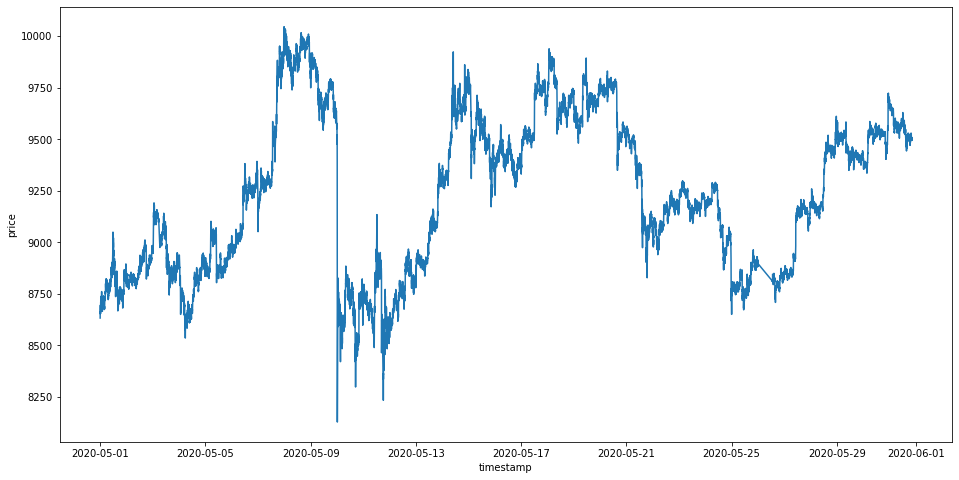

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x=prices.index, y=prices, ax=ax)

There is a clear trend in the prices above, so the price time series is not stationary.

### 1.2 Plot log return

In [8]:
log_returns = np.log(time_bars['vwap']).diff().dropna().rename('log_return')

In [9]:
log_returns.describe(percentiles=[0.5, 0.95])

count    42891.000000
mean         0.000002
std          0.001026
min         -0.033504
50%          0.000007
95%          0.001246
max          0.077201
Name: log_return, dtype: float64

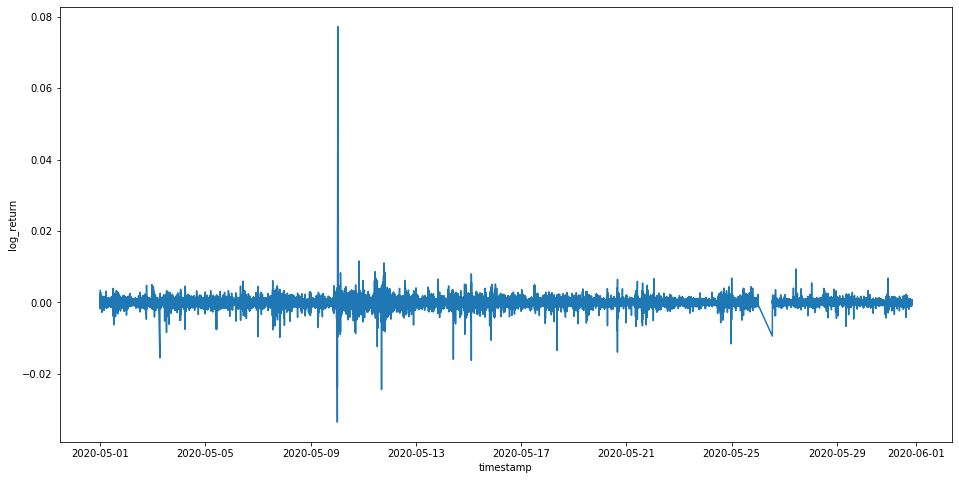

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x=log_returns.index, y=log_returns, ax=ax)

### 1.3 Plot squared log return

In [11]:
log_returns_squared = log_returns.pow(2)

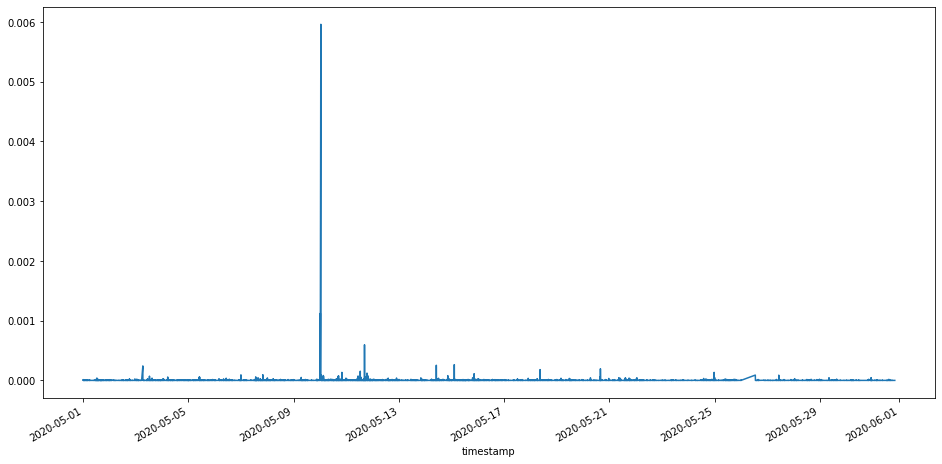

In [12]:
fig, ax = plt.subplots(figsize=(16, 8))

log_returns_squared.plot(ax=ax)

We can see there is a volatility clustering phenomenon.

### 1.4 ADF test

In [13]:
adf_result = ADF(log_returns)

In [14]:
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Used lag: %f' % adf_result[2])
print('Number of observations: %f' % adf_result[3])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -35.070141
p-value: 0.000000
Used lag: 38.000000
Number of observations: 42852.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In the output above, we can see that ADF statistic is less than the value at 1%. Besides, and the p-value is less than `0.05`. Both values reject the null hypothesis, therefore log return time series is stationary.

## 2. ARMA

### 2.1 Estimating the orders of `p` and `q`

Usually we use partial autocorrelation to estimate the order `p` of `AR(p)` model and use autocorrelation to estimate the order `q` of `MA(q)` model, so let's first plot ACF and PACF.

Rules to identify the orders of AR or MA:

* The lag beyond which the PACF cuts off is the indicated order of AR.
* The lag beyond which the ACF cuts off is the indicated order of MA.

#### Plot ACF and PACF

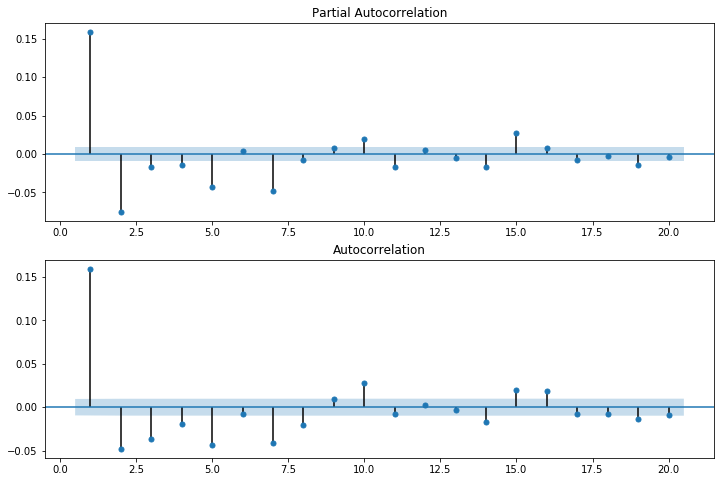

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(log_returns, lags=20, zero=False, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(log_returns.values.squeeze(), lags=20, zero=False, ax=ax2)

* The PACF shuts off after lag 2.
* The ACF shuts off after lag 3.

So we can tentatively set `p=2` and `q=3`.

### 2.2 Train the ARMA model

In [16]:
# ValueWarning: A date index has been provided, but it has no associated frequency information
index_bak = log_returns.index
log_returns.index = pd.DatetimeIndex(log_returns.index).to_period('T')

In [17]:
arma_model = sm.tsa.arima.ARIMA(log_returns, order=(2, 0, 3)).fit()  # ARMA(2,3)

In [18]:
# arma_model.summary()

In [19]:
print(arma_model.aic, arma_model.bic, arma_model.hqic)

-468583.3514870382 -468522.68656598934 -468564.2120837475


In [20]:
print(arma_model.params)

const    -4.015829e-07
ar.L1     8.832102e-08
ar.L2    -2.662828e-08
ma.L1     8.831572e-08
ma.L2    -2.663374e-08
ma.L3    -2.039327e-08
sigma2    1.044881e-06
dtype: float64


### 2.3 White Noise Test on residuals

In [21]:
sm.stats.acorr_ljungbox(arma_model.resid.values, lags=1, return_df=True)

,lb_stat,lb_pvalue
1,1082.365737,2.247084e-237


The p-value of Ljung-Box test is much greater than 0.05, which indicates that residuals are white noise.

## 3. GARCH

### 3.1 Bartlett's Test on squared residuals

In [22]:
squared_residuals = arma_model.resid.pow(2)

In [23]:
stats.bartlett(squared_residuals[:squared_residuals.size//2], squared_residuals[squared_residuals.size//2:])

BartlettResult(statistic=84875.17023907191, pvalue=0.0)

The very small p-value suggests that the populations do not have equal variances. Therefore it is reasonable to use GARCH to model residuals.

### 3.2 Plot ACF and PACF of squared residuals

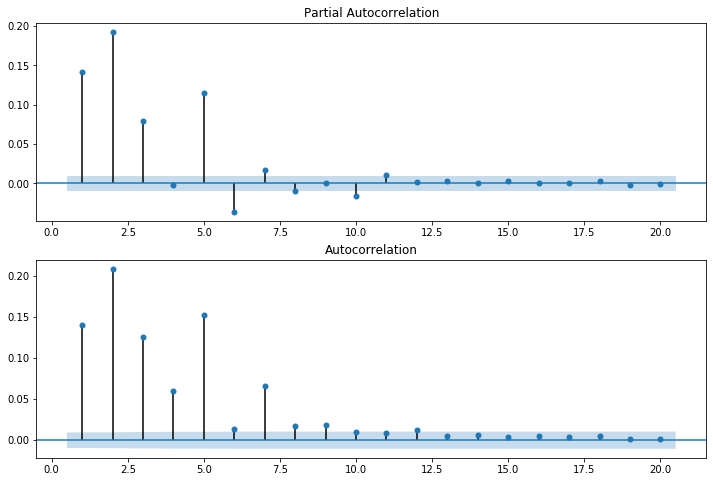

In [24]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(squared_residuals, lags=20, zero=False, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(squared_residuals.values.squeeze(), lags=20, zero=False, ax=ax2)

In the two figures above we see significant positive autocorrelations in variance out to perhaps 7 lag time steps.

This might make a reasonable value for the parameter in the ARCH model.

### 3.3 Train the GARCH model

In [25]:
residuals = arma_model.resid.copy(deep=True)
residuals.index = index_bak

In [26]:
garch_model = arch_model(residuals, mean='Zero', p=6, q=7, o=1, dist='StudentsT', rescale=True)

In [27]:
# fit model
garch_model_result = garch_model.fit(update_freq=0, disp='off')

In [28]:
garch_model_result.loglikelihood

-44026.25800677869

In [29]:
# garch_model_result.conditional_volatility

In [30]:
# garch_model_result.summary()

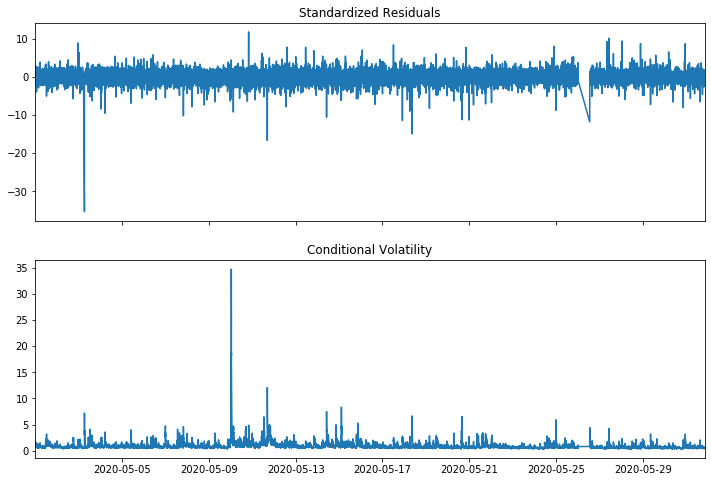

In [31]:
fig = garch_model_result.plot()
fig.set_size_inches(12, 8)

## References

* [github.com/bashtage/arch](https://github.com/bashtage/arch)
* [ARCH Modeling](https://nbviewer.jupyter.org/github/bashtage/arch/blob/master/examples/univariate_volatility_modeling.ipynb)
* [How to Model Volatility with ARCH and GARCH for Time Series Forecasting in Python](https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/)
* [What is fitted in a GARCH: residual or log-return? - Cross Validated](https://stats.stackexchange.com/a/71974/21732)
* [Does the GARCH approach model prices or returns? - Cross Validated](https://stats.stackexchange.com/q/27420/21732)
* [ARIMA+GARCH Trading Strategy on the S&P500 Stock Market Index Using R](https://www.quantstart.com/articles/ARIMA-GARCH-Trading-Strategy-on-the-SP500-Stock-Market-Index-Using-R/)
* [statistics - ARMA+GARCH day-trading strategy - Quantitative Finance Stack Exchange](https://quant.stackexchange.com/q/47012/4746)